In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt

In [2]:
def replace_timestamps_with_step_times(df):
    step_names = ["prefetch", "fasterq_dump", "salmon", "deseq2_salmon", "star", "deseq2_star"]
    for step_name in step_names:
        if step_name+"_start_time" in df.columns:
            start_times = (pd.to_datetime(df[f"{step_name}_start_time"]) - dt.datetime(1970,1,1)).dt.total_seconds()
            end_times = (pd.to_datetime(df[f"{step_name}_end_time"]) - dt.datetime(1970,1,1)).dt.total_seconds()
            df[f"{step_name} [s]"] = end_times - start_times

    return df

In [3]:
df_prices = pd.DataFrame(data={"price_per_h": [0.4536, 0.5040, 0.5292, 0.6086]}, index=["r6a.2xlarge", "r6i.2xlarge", "r7i.2xlarge", "r7a.2xlarge"])
df_prices

,price_per_h
r6a.2xlarge,0.4536
r6i.2xlarge,0.5040
r7i.2xlarge,0.5292
r7a.2xlarge,0.6086


In [4]:
df_r6a = replace_timestamps_with_step_times(pd.read_csv("data/r6a.2xlarge.csv", index_col=0))
df_r6i = replace_timestamps_with_step_times(pd.read_csv("data/r6i.2xlarge.csv", index_col=0))
df_r7a = replace_timestamps_with_step_times(pd.read_csv("data/r7a.2xlarge.csv", index_col=0))
df_r7i = replace_timestamps_with_step_times(pd.read_csv("data/r7i.2xlarge.csv", index_col=0))

In [5]:
print(f"r6a.2xlarge mean STAR execution time: {(df_r6a['star [s]'].sum() / 3600):.2f} h")
print(f"r6i.2xlarge mean STAR execution time: {(df_r6i['star [s]'].sum() / 3600):.2f} h")
print(f"r7a.2xlarge mean STAR execution time: {(df_r7a['star [s]'].sum() / 3600):.2f} h")
print(f"r7i.2xlarge mean STAR execution time: {(df_r7i['star [s]'].sum() / 3600):.2f} h")

r6a.2xlarge mean STAR execution time: 8.00 h
r6i.2xlarge mean STAR execution time: 8.04 h
r7a.2xlarge mean STAR execution time: 5.48 h
r7i.2xlarge mean STAR execution time: 7.66 h


In [6]:
print(f"r6a.2xlarge STAR total cost: {((df_r6a['star [s]'].sum() / 3600) * df_prices.loc['r6a.2xlarge', 'price_per_h']):.2f} $")
print(f"r6i.2xlarge STAR total cost: {((df_r6i['star [s]'].sum() / 3600) * df_prices.loc['r6i.2xlarge', 'price_per_h']):.2f} $")
print(f"r7a.2xlarge STAR total cost: {((df_r7a['star [s]'].sum() / 3600) * df_prices.loc['r7a.2xlarge', 'price_per_h']):.2f} $")
print(f"r7i.2xlarge STAR total cost: {((df_r7i['star [s]'].sum() / 3600) * df_prices.loc['r7i.2xlarge', 'price_per_h']):.2f} $")

r6a.2xlarge STAR total cost: 3.63 $
r6i.2xlarge STAR total cost: 4.05 $
r7a.2xlarge STAR total cost: 3.33 $
r7i.2xlarge STAR total cost: 4.05 $


In [7]:
def non_star_steps_percent(df):
    return ((df["prefetch [s]"] + df["fasterq_dump [s]"] + df["deseq2_star [s]"]) / (df["prefetch [s]"] + df["fasterq_dump [s]"] + df["star [s]"] + df["deseq2_star [s]"])).mean()

print(f"r6a.2xlarge non-STAR steps total execution time percent : {non_star_steps_percent(df_r6a):.2f} %")
print(f"r6i.2xlarge non-STAR steps total execution time percent : {non_star_steps_percent(df_r6i):.2f} %")
print(f"r7a.2xlarge non-STAR steps total execution time percent : {non_star_steps_percent(df_r7a):.2f} %")
print(f"r7i.2xlarge non-STAR steps total execution time percent : {non_star_steps_percent(df_r7i):.2f} %")

r6a.2xlarge non-STAR steps total execution time percent : 0.24 %
r6i.2xlarge non-STAR steps total execution time percent : 0.25 %
r7a.2xlarge non-STAR steps total execution time percent : 0.31 %
r7i.2xlarge non-STAR steps total execution time percent : 0.25 %


In [8]:
with open('data/logs-insights-results.csv', 'r') as file:
    lines = file.readlines()

extracted_values = []
for line in lines:
    if "Max memory needed for sorting = " in line:
        value = line.split('=')[1].strip()
        extracted_values.append(int(value))

print(f"Max memory needed for sorting of 50 files: {np.max(extracted_values) / 1024**3:.2f} GiB")

Max memory needed for sorting of 50 files: 20.44 GiB


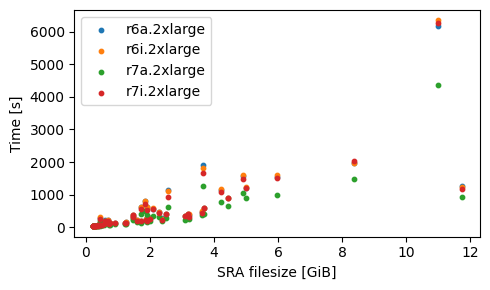

In [9]:
fig, ax = plt.subplots(figsize=(5, 3))

ax.scatter(df_r6a['SRR_filesize_bytes'] / 1024**3, df_r6a['star [s]'], label='r6a.2xlarge', s=10)
ax.scatter(df_r6i['SRR_filesize_bytes'] / 1024**3, df_r6i['star [s]'], label='r6i.2xlarge', s=10)
ax.scatter(df_r7a['SRR_filesize_bytes'] / 1024**3, df_r7a['star [s]'], label='r7a.2xlarge', s=10)
ax.scatter(df_r7i['SRR_filesize_bytes'] / 1024**3, df_r7i['star [s]'], label='r7i.2xlarge', s=10)

ax.set_xlabel('SRA filesize [GiB]')
ax.set_ylabel('Time [s]')

ax.legend()
plt.tight_layout()
# plt.savefig('instance_type_times_filesize.pdf')
plt.show()

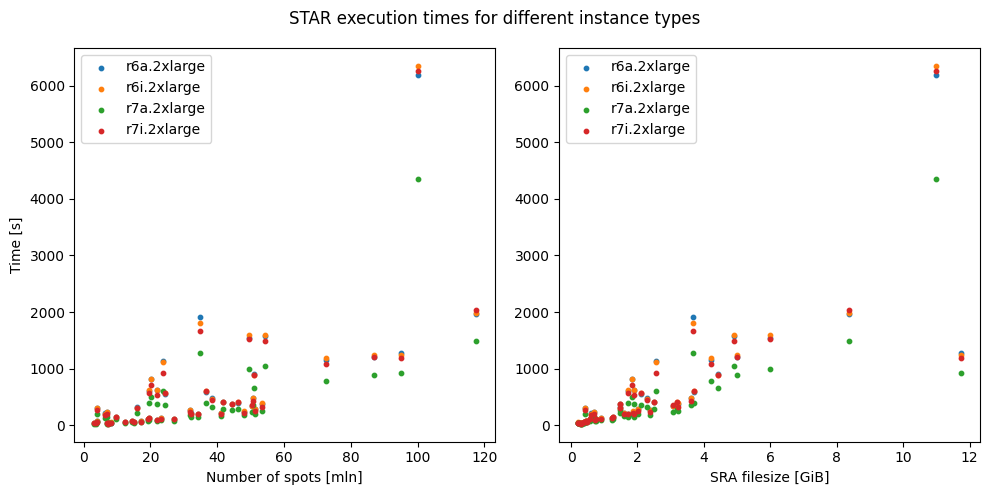

In [10]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

ax[0].scatter(df_r6a['n_spots'] / 1000**2, df_r6a['star [s]'], label='r6a.2xlarge', s=10)
ax[0].scatter(df_r6i['n_spots'] / 1000**2, df_r6i['star [s]'], label='r6i.2xlarge', s=10)
ax[0].scatter(df_r7a['n_spots'] / 1000**2, df_r7a['star [s]'], label='r7a.2xlarge', s=10)
ax[0].scatter(df_r7i['n_spots'] / 1000**2, df_r7i['star [s]'], label='r7i.2xlarge', s=10)

ax[1].scatter(df_r6a['SRR_filesize_bytes'] / 1024**3, df_r6a['star [s]'], label='r6a.2xlarge', s=10)
ax[1].scatter(df_r6i['SRR_filesize_bytes'] / 1024**3, df_r6i['star [s]'], label='r6i.2xlarge', s=10)
ax[1].scatter(df_r7a['SRR_filesize_bytes'] / 1024**3, df_r7a['star [s]'], label='r7a.2xlarge', s=10)
ax[1].scatter(df_r7i['SRR_filesize_bytes'] / 1024**3, df_r7i['star [s]'], label='r7i.2xlarge', s=10)

ax[0].set_xlabel('Number of spots [mln]')
ax[1].set_xlabel('SRA filesize [GiB]')
ax[0].set_ylabel('Time [s]')
fig.suptitle('STAR execution times for different instance types')

ax[0].legend()
ax[1].legend()
plt.tight_layout()
# plt.savefig('instance_type_times.pdf')
plt.show()